# Crypto Currencies - Time Series Forecasting
# <font color='blue'>0. Identification for Business Requirements</font> <a class="anchor" id="first-bullet"></a>

### A Short Description About the Dataset & It's Source


####  Dataset of Bitcoin Historical Data

## <font color= blue >1. Importing the Necessary Libraries</font> <a class="anchor" id="second-bullet"></a>

In [1]:
#!pip install cryptocmd
#!pip install arch

In [2]:
# Standard library imports
import os
import time
import warnings
import sys
import requests
import os 
import pickle

# Third party imports
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.metrics import r2_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from cryptocmd import CmcScraper
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import LSTM, Dropout, Dense, Input, Attention
from keras.models import Model
from keras.layers import ConvLSTM2D, Dropout, Flatten, Dense
from keras.models import Sequential
from prettytable import PrettyTable
# Necessary Imports
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score



# Local application imports
# Import other necessary libraries and modules here
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, Span, Range1d
from bokeh.layouts import column
from bokeh.models.widgets import Button
from bokeh.models.callbacks import CustomJS
from bokeh.themes import Theme
from math import pi
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource, WheelZoomTool
import pandas as pd
import tensorflow as tf

warnings.filterwarnings('ignore')
# Set the options
pd.set_option('display.float_format', '{:.3f}'.format)

# Block 1 - CryptoData

In [3]:
# Block 1 - load data with CmC Scrapper
class CryptoData:
    """
    This class is responsible for fetching and formatting cryptocurrency data.

    Input:
        crypto_symbol (str): The symbol of the cryptocurrency, e.g., "BTC" for Bitcoin.

    Methods:
        get_cryptocmd_data: Fetches cryptocurrency data and returns a formatted DataFrame.
        get_display_data: Fetches and formats cryptocurrency data for display purposes.
    """
    def __init__(self, crypto_symbol: str):
        self.crypto_symbol = crypto_symbol

    def _fetch_cryptocmd_data(self) -> pd.DataFrame:
        try:
            scraper = CmcScraper(self.crypto_symbol)
            df = scraper.get_dataframe()
            if not {'Date', 'Open', 'High', 'Low', 'Close', 'Market Cap', 'Volume'}.issubset(df.columns):
                raise ValueError("Some expected columns are missing in the data.")
            return df
        except Exception as e:
            print(f'An error occurred while fetching data: {e}')
            raise  # Propagate the exception

    def get_cryptocmd_data(self) -> pd.DataFrame:
        df = self._fetch_cryptocmd_data()
        df.set_index('Date', inplace=True)
        df.index = pd.to_datetime(df.index)
        return df.round(2)

    @staticmethod
    def _format_monetary_value(value: float) -> str:
        return "${:,.2f}".format(value)

    @staticmethod
    def _format_volume_value(value: float) -> str:
        if value > 1e9:
            return "{:.2f}B".format(value/1e9)
        elif value > 1e6:
            return "{:.2f}M".format(value/1e6)
        else:
            return "{:,.2f}".format(value)

    def get_display_data(self) -> pd.DataFrame:
        display_df = self.get_cryptocmd_data().copy()
        monetary_columns = ['Open', 'High', 'Low', 'Close']
        display_df[monetary_columns] = display_df[monetary_columns].applymap(self._format_monetary_value)

        # Check and apply volume formatting only if they are of numeric type
        volume_like_columns = ['Volume', 'Market Cap']
        for column in volume_like_columns:
            if pd.api.types.is_numeric_dtype(display_df[column]):
                display_df[column] = display_df[column].apply(self._format_volume_value)

        return display_df

In [4]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()
display_data = crypto.get_display_data()
display_data

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2023-06-30,"$30,441.35","$31,256.86","$29,600.28","$30,477.25",26.39B,591.76B
2023-06-29,"$30,086.19","$30,796.25","$30,057.20","$30,445.35",13.18B,591.11B
2023-06-28,"$30,696.56","$30,703.28","$29,921.82","$30,086.25",14.57B,584.11B
2023-06-27,"$30,274.32","$31,006.79","$30,236.65","$30,688.16",16.43B,595.77B
2023-06-26,"$30,480.52","$30,636.03","$29,955.74","$30,271.13",16.49B,587.65B
...,...,...,...,...,...,...
2013-05-02,$116.38,$125.60,$92.28,$105.21,0.00,1.17B
2013-05-01,$139.00,$139.89,$107.72,$116.99,0.00,1.30B
2013-04-30,$144.00,$146.93,$134.05,$139.00,0.00,1.54B


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Block 5 - Data Pre-Processing

In [5]:
class DataPreprocessing:
    def __init__(self, data, target_columns, seq_length=5):
        self.data = data.sort_index(ascending=True)
        if isinstance(target_columns, list):
            missing_cols = [col for col in target_columns if col not in data.columns]
        else:
            missing_cols = [] if target_columns in data.columns else [target_columns]
        if missing_cols:
            raise ValueError(f"Columns {missing_cols} are not in the input dataframe.")
        self.target_columns = target_columns
        self.is_target_list = isinstance(self.target_columns, list)
        self.data_scaled = None  # Initialize the data_scaled attribute
        self.seq_length = seq_length

    def normalize_and_scale(self):
        scaler_filepath = './assets/scaler_multi.pkl' if self.is_target_list else './assets/scaler_uni.pkl'
        self.scaler = StandardScaler()
        self.data_scaled = self._scale_data()
            
        with open(scaler_filepath, 'wb') as file:
            pickle.dump(self.scaler, file)

        return self.data_scaled

    def _scale_data(self):
        if self.is_target_list:
            return self.scaler.fit_transform(self.data[self.target_columns])
        else:
            # reshaping the data to (-1, 1) if it's not a list
            return self.scaler.fit_transform(self.data[[self.target_columns]])

    def split_data(self, splitter, output_shape='3D'):
        if self.data_scaled is None:
            raise ValueError("Please call 'normalize_and_scale' method before splitting the data.")
        if not 0 <= splitter <= 1:
            raise ValueError("'splitter' should be in range [0, 1].")

        # Splitting into training and test datasets
        train_data, test_data = train_test_split(self.data_scaled, test_size=(1-splitter), shuffle=False)

        X_train, y_train = self.prepare_data(train_data)
        X_test, y_test = self.prepare_data(test_data)

        if output_shape == '3D':
            X_train, X_test = np.array(X_train), np.array(X_test)
        elif output_shape != '2D':
            raise ValueError("'output_shape' value must be either '2D' or '3D'.")

        return X_train, np.array(y_train), X_test, np.array(y_test)

    def prepare_data(self, data):
        X, y = [], []
        for i in range(self.seq_length, len(data)):
            X.append(data[i-self.seq_length:i])
            y.append(data[i - 1, self.data.columns.get_loc('Close')] if self.is_target_list else data[i - 1, 0])
        return X, y

    def visualize_split(self, train_data, test_data):
        target_data_restored = self.data[self.target_columns]

        if isinstance(self.target_columns, list):
            y_train_restored = target_data_restored[:len(train_data)]
            y_test_restored = target_data_restored[len(train_data):]
        else:
            y_train_restored = target_data_restored[:len(train_data)].values
            y_test_restored = target_data_restored[len(train_data):].values

        train_dates = self.data.index[:len(train_data)]
        test_dates = self.data.index[-len(test_data):]

        p = figure(width=950, height=500, x_axis_type="datetime", title="Training and Testing Data")
        p.xgrid.grid_line_color = "gray"
        p.ygrid.grid_line_color = "gray"
        p.xgrid.grid_line_alpha = 0.3
        p.ygrid.grid_line_alpha = 0.3

        # Training Data Line
        p.line(train_dates, y_train_restored, color='blue', legend_label='Training Data', line_width=2)
        p.line(test_dates, y_test_restored, color='orange', legend_label='Testing Data', line_width=2)
        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("Value", "$@y{0,0.00}")],formatters={"@x": "datetime"})

        p.add_tools(hover)
        p.toolbar.logo = None
        show(p)

## Block 5.1 - Uni and Multi LSTM Processing 

In [6]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()

target_columns_uni = 'Close'  # univariate target
target_columns_multi = ['Open', 'High', 'Low', 'Close']  # multivariate targets
seq_length = 5  # sequence length
splitter = 0.8  # split ratio for train-test split

In [7]:
# For Univariate LSTM model with 'Close' column
preprocessor_uni = DataPreprocessing(data, target_columns_uni)
data_normalized_uni = preprocessor_uni.normalize_and_scale()
X_train_close, y_train_close, X_test_close, y_test_close = preprocessor_uni.split_data(splitter, output_shape='3D')
print(X_train_close.shape, y_train_close.shape, X_test_close.shape, y_test_close.shape)
preprocessor_uni.visualize_split(y_train_close, y_test_close)

(2967, 5, 1) (2967,) (739, 5, 1) (739,)


In [8]:
# For Multivariate LSTM model with ('Open', 'High', 'Low', 'Close') columns
target_columns_multi = ['Open', 'High', 'Low', 'Close']
preprocessor_multi = DataPreprocessing(data, target_columns_multi)
data_normalized_multi = preprocessor_multi.normalize_and_scale()
X_train_ohlcv, y_train_ohlcv, X_test_ohlcv, y_test_ohlcv = preprocessor_multi.split_data(splitter=0.2, output_shape='3D')
print(X_train_ohlcv.shape, y_train_ohlcv.shape, X_test_ohlcv.shape, y_test_ohlcv.shape)
preprocessor_uni.visualize_split(y_train_close, y_test_close)

(738, 5, 4) (738,) (2968, 5, 4) (2968,)


# Block 7 - LSTM Class

In [18]:
class LSTM_Models:
    def __init__(self, X_train, y_train, X_test, y_test, model, scaler_type):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = model
        self.scaler_type = scaler_type
        
        if self.scaler_type == "uni":
            scaler_filepath = './assets/scaler_uni.pkl'
        else:
            scaler_filepath = './assets/scaler_multi.pkl'
        
        with open(scaler_filepath, 'rb') as file:
            self.scaler = pickle.load(file)
    
    def train_model(self, epochs=100, batch_size=50):
        try:
            tf.compat.v1.reset_default_graph()
            self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, verbose=2,
                                          validation_data=(self.X_test, self.y_test), shuffle=False)
        except Exception as e:
            return str(e)

    def make_predictions(self):
        train_predict = self.model.predict(self.X_train)
        test_predict = self.model.predict(self.X_test)

        num_lstm_layers = sum([isinstance(layer, LSTM) for layer in self.model.layers])

        if len(train_predict.shape) == 1 or num_lstm_layers > 1:
            train_predict = train_predict.reshape(-1, 1)
        if len(test_predict.shape) == 1 or num_lstm_layers > 1:
            test_predict = test_predict.reshape(-1, 1)

        train_predict = self.scaler.inverse_transform(train_predict)
        test_predict = self.scaler.inverse_transform(test_predict)

        y_train_rescaled = self.scaler.inverse_transform(self.y_train.reshape(-1, 1))
        y_test_rescaled = self.scaler.inverse_transform(self.y_test.reshape(-1, 1))

        print(f"Train predict shape: {train_predict.shape}")
        print(f"Test predict shape: {test_predict.shape}")
        print(f"Y Train rescaled shape: {y_train_rescaled.shape}")
        print(f"Y Test rescaled shape: {y_test_rescaled.shape}")

        train_comparison_df = pd.DataFrame({
            'Actual': y_train_rescaled.ravel(),
            'Predict': train_predict.ravel()
        })

        test_comparison_df = pd.DataFrame({
            'Actual': y_test_rescaled.ravel(),
            'Predict': test_predict.ravel()
        })

        return train_comparison_df, test_comparison_df

    def evaluate_model(self, train_comparison_df, test_comparison_df):
            metrics = {
                'RMSE': mean_squared_error,
                'R2 Score': r2_score,
                'MAE': mean_absolute_error,
                'Explained Variance': explained_variance_score,
            }

            # Initialize an empty dictionary to hold metric results
            evaluation_results = {}

            # Calculate metrics for both training and test data
            for name, func in metrics.items():
                evaluation_results[name] = [func(train_comparison_df['Actual'], train_comparison_df['Predict']),
                                            func(test_comparison_df['Actual'], test_comparison_df['Predict'])]

            # Convert the results to a DataFrame
            evaluation_df = pd.DataFrame(evaluation_results, index=['Train_Data C', 'Test_Data C'])
            evaluation_df = evaluation_df.transpose().round(3)
            # Return the evaluation DataFrame
            return evaluation_df

    def plot_history(self):
        plt.plot(self.history.history['loss'], label='train')
        plt.plot(self.history.history['val_loss'], label='test')
        plt.legend()
        plt.title('Mean Squared Error between Train and Test Sets')
        plt.show()

    def plot_predictions(self, train_comparison_df, test_comparison_df):
        plt.figure(figsize=(14, 7))
        # Plot the actual and predicted values for the training data
        plt.subplot(1, 2, 1)
        plt.plot(train_comparison_df['Actual'], label='Actual')
        plt.plot(train_comparison_df['Predict'], label='Predict')
        plt.title('Training Data: Actual vs Predicted')
        plt.legend()
        # Plot the actual and predicted values for the testing data
        plt.subplot(1, 2, 2)
        plt.plot(test_comparison_df['Actual'], label='Actual')
        plt.plot(test_comparison_df['Predict'], label='Predict')
        plt.title('Testing Data: Actual vs Predicted')
        plt.legend()
        # Show the plot
        plt.show()

## Block 7.1 - LSTM Models

In [19]:
# Model 1 - Triple Layer
lay_model = Sequential()
lay_model.add(LSTM(128,activation="tanh",return_sequences=True, input_shape=(5, 1)))
lay_model.add(Dropout(0.15))
lay_model.add(LSTM(128,activation="tanh", return_sequences=True))
lay_model.add(Dropout(0.20))
lay_model.add(LSTM(256, activation="tanh",return_sequences=False))
lay_model.add(Dropout(0.25))
lay_model.add(Dense(1))
lay_model.compile(loss='mean_squared_error', optimizer='adam')
lay_model.summary()


# For Univariate LSTM model with 'Close' column
uni_model = Sequential()
uni_model.add(LSTM(256,activation="tanh",input_shape=(5,1)))
uni_model.add(Dropout(0.15))
uni_model.add(Dense(1))
uni_model.compile(loss='mean_squared_error', optimizer='adam')
uni_model.summary()


# For Multivariate LSTM model with ('Open', 'High', 'Low', 'Close') columns
multi_model = Sequential()
multi_model.add(LSTM(256,activation="tanh",input_shape=(5,4)))
multi_model.add(Dropout(0.15))
multi_model.add(Dense(1))
multi_model.compile(loss='mean_squared_error', optimizer='adam')
multi_model.summary()

target_columns_uni = 'Close'  # univariate target
target_columns_multi = ['Open', 'High', 'Low', 'Close']  # multivariate targets
seq_length = 5  # sequence length
splitter = 0.8  # split ratio for train-test split

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               394240    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 2

### Block 7.1.1 - LSTM Layers

In [20]:
# For Univariate LSTM model with 'Close' column
preprocessor_lay = DataPreprocessing(data, target_columns_uni)
data_normalized_lay = preprocessor_lay.normalize_and_scale()
X_train_l, y_train_l, X_test_l, y_test_l = preprocessor_lay.split_data(splitter=0.8, output_shape='3D')
print(X_train_l.shape, y_train_l.shape, X_test_l.shape, y_test_l.shape)

lstm_layer = LSTM_Models(X_train_l, y_train_l, X_test_l, y_test_l, lay_model, 'uni')
lstm_layer.train_model(epochs=100, batch_size=50)

(2967, 5, 1) (2967,) (739, 5, 1) (739,)
Epoch 1/100
60/60 - 5s - loss: 0.1495 - val_loss: 0.9293 - 5s/epoch - 91ms/step
Epoch 2/100
60/60 - 1s - loss: 1.6449 - val_loss: 1.8092 - 786ms/epoch - 13ms/step
Epoch 3/100
60/60 - 1s - loss: 0.0925 - val_loss: 0.0322 - 775ms/epoch - 13ms/step
Epoch 4/100
60/60 - 1s - loss: 0.1052 - val_loss: 0.1166 - 822ms/epoch - 14ms/step
Epoch 5/100
60/60 - 1s - loss: 0.3082 - val_loss: 1.7009 - 816ms/epoch - 14ms/step
Epoch 6/100
60/60 - 1s - loss: 0.1198 - val_loss: 0.5626 - 840ms/epoch - 14ms/step
Epoch 7/100
60/60 - 1s - loss: 0.0160 - val_loss: 0.0310 - 821ms/epoch - 14ms/step
Epoch 8/100
60/60 - 1s - loss: 0.0125 - val_loss: 0.0299 - 799ms/epoch - 13ms/step
Epoch 9/100
60/60 - 1s - loss: 0.0309 - val_loss: 0.0587 - 814ms/epoch - 14ms/step
Epoch 10/100
60/60 - 1s - loss: 0.0205 - val_loss: 0.0245 - 814ms/epoch - 14ms/step
Epoch 11/100
60/60 - 1s - loss: 0.0584 - val_loss: 0.1386 - 797ms/epoch - 13ms/step
Epoch 12/100
60/60 - 1s - loss: 0.0237 - val_los

Epoch 99/100
60/60 - 1s - loss: 0.0721 - val_loss: 0.0401 - 845ms/epoch - 14ms/step
Epoch 100/100
60/60 - 1s - loss: 0.0401 - val_loss: 0.1713 - 810ms/epoch - 14ms/step


24/24 [==============================] - 0s 5ms/step
Train predict shape: (2967, 1)
Test predict shape: (739, 1)
Y Train rescaled shape: (2967, 1)
Y Test rescaled shape: (739, 1)


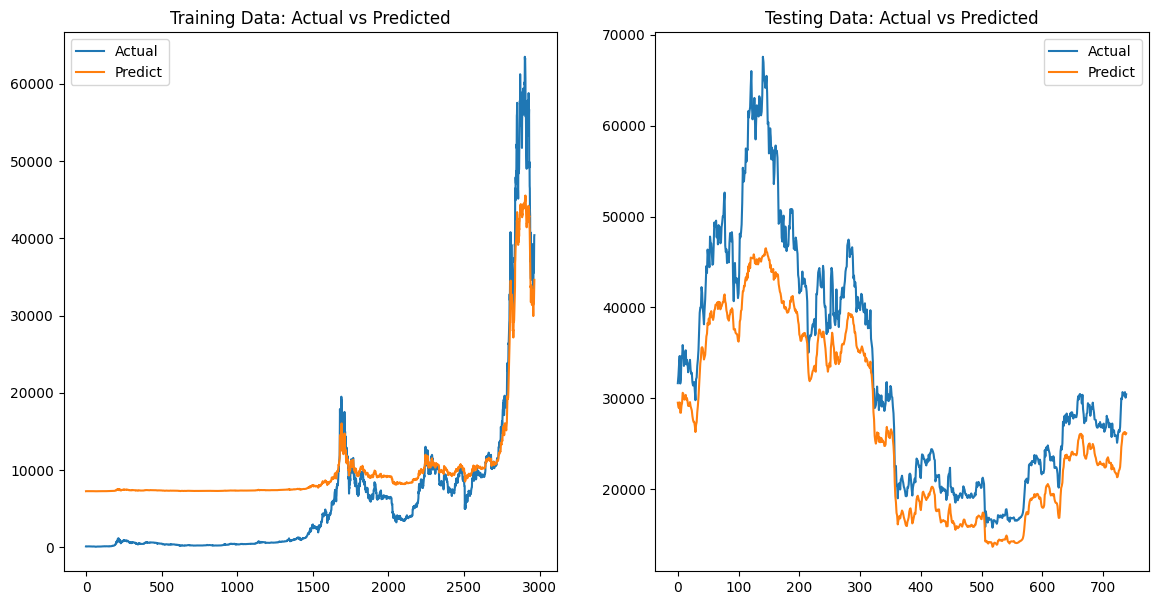

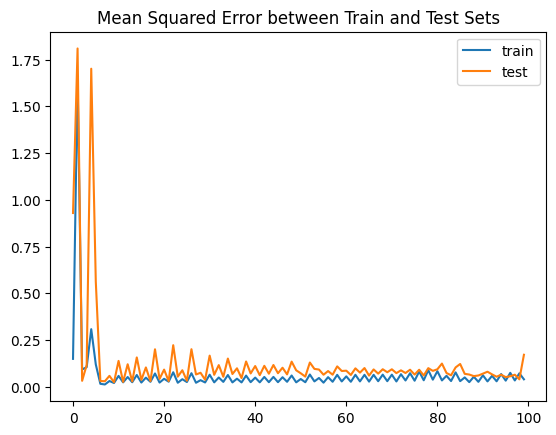

                    Train_Data C  Test_Data C
RMSE                32468034.712 41404303.127
R2 Score                   0.736        0.748
MAE                     4949.570     5451.689
Explained Variance         0.850        0.929


In [21]:
train_comparison_df_l,test_comparison_df_l = lstm_layer.make_predictions()
lstm_layer.plot_predictions(train_comparison_df_l, test_comparison_df_l)
lstm_layer.plot_history()
results_df_l = lstm_layer.evaluate_model(train_comparison_df_l, test_comparison_df_l)
print(results_df_l)

### Block 1.1.1 - LSTM Uni

In [22]:
# For Univariate LSTM model with 'Close' column
preprocessor_uni = DataPreprocessing(data, target_columns_uni)
data_normalized_uni = preprocessor_uni.normalize_and_scale()
X_train_uni, y_train_uni, X_test_uni, y_test_uni = preprocessor_uni.split_data(splitter=0.8, output_shape='3D')
print(X_train_uni.shape, y_train_uni.shape, X_test_uni.shape, y_test_uni.shape)

lstm_uni = LSTM_Models(X_train_uni, y_train_uni, X_test_uni, y_test_uni, uni_model, 'uni')
lstm_uni.train_model(epochs=100, batch_size=50)

(2967, 5, 1) (2967,) (739, 5, 1) (739,)
Epoch 1/100
60/60 - 2s - loss: 0.0551 - val_loss: 0.1409 - 2s/epoch - 41ms/step
Epoch 2/100
60/60 - 1s - loss: 0.0376 - val_loss: 0.2658 - 581ms/epoch - 10ms/step
Epoch 3/100
60/60 - 1s - loss: 0.0659 - val_loss: 0.0246 - 1s/epoch - 17ms/step
Epoch 4/100
60/60 - 1s - loss: 0.1780 - val_loss: 1.0521 - 547ms/epoch - 9ms/step
Epoch 5/100
60/60 - 0s - loss: 0.3820 - val_loss: 1.2761 - 474ms/epoch - 8ms/step
Epoch 6/100
60/60 - 0s - loss: 0.0199 - val_loss: 0.0296 - 456ms/epoch - 8ms/step
Epoch 7/100
60/60 - 0s - loss: 0.0880 - val_loss: 0.3454 - 468ms/epoch - 8ms/step
Epoch 8/100
60/60 - 0s - loss: 0.0186 - val_loss: 0.0209 - 444ms/epoch - 7ms/step
Epoch 9/100
60/60 - 0s - loss: 0.0657 - val_loss: 0.2333 - 493ms/epoch - 8ms/step
Epoch 10/100
60/60 - 0s - loss: 0.0178 - val_loss: 0.0266 - 456ms/epoch - 8ms/step
Epoch 11/100
60/60 - 1s - loss: 0.0517 - val_loss: 0.1588 - 527ms/epoch - 9ms/step
Epoch 12/100
60/60 - 1s - loss: 0.0205 - val_loss: 0.0245 -

60/60 - 1s - loss: 0.0158 - val_loss: 0.0253 - 580ms/epoch - 10ms/step
Epoch 100/100
60/60 - 1s - loss: 0.0117 - val_loss: 0.0238 - 543ms/epoch - 9ms/step


24/24 [==============================] - 0s 3ms/step
Train predict shape: (2967, 1)
Test predict shape: (739, 1)
Y Train rescaled shape: (2967, 1)
Y Test rescaled shape: (739, 1)


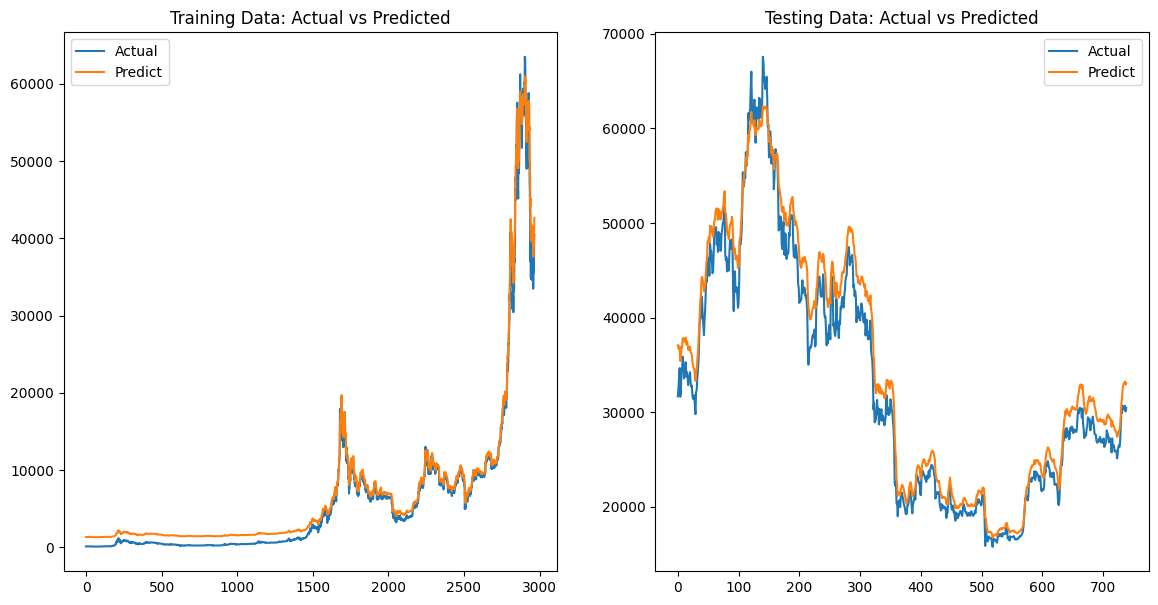

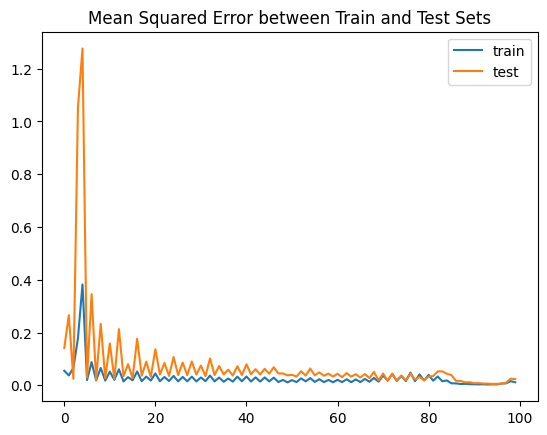

                    Train_Data C  Test_Data C
RMSE                 1225036.242  5762477.286
R2 Score                   0.990        0.965
MAE                      926.960     2076.752
Explained Variance         0.997        0.987


In [23]:
train_comparison_df_uni,test_comparison_df_uni = lstm_uni.make_predictions()
lstm_uni.plot_predictions(train_comparison_df_uni, test_comparison_df_uni)
lstm_uni.plot_history()
results_df_uni = lstm_uni.evaluate_model(train_comparison_df_uni, test_comparison_df_uni)
print(results_df_uni)

### Block 1.1.1 - LSTM Multi

In [24]:
# For Multivariate LSTM model with ('Open', 'High', 'Low', 'Close') columns
preprocessor_multi = DataPreprocessing(data, target_columns_multi)
data_normalized_multi = preprocessor_multi.normalize_and_scale()
X_train_ohlcv, y_train_ohlcv, X_test_ohlcv, y_test_ohlcv = preprocessor_multi.split_data(splitter=0.8, output_shape='3D')
print(X_train_ohlcv.shape, y_train_ohlcv.shape, X_test_ohlcv.shape, y_test_ohlcv.shape)

lstm_multivariate_ohlcv = LSTM_Models(X_train_ohlcv, y_train_ohlcv, X_test_ohlcv, y_test_ohlcv, multi_model, 'uni')
lstm_multivariate_ohlcv.train_model(epochs=100, batch_size=50)

(2967, 5, 4) (2967,) (739, 5, 4) (739,)
Epoch 1/100
60/60 - 3s - loss: 0.0518 - val_loss: 0.2307 - 3s/epoch - 42ms/step
Epoch 2/100
60/60 - 1s - loss: 0.0314 - val_loss: 0.4386 - 588ms/epoch - 10ms/step
Epoch 3/100
60/60 - 1s - loss: 0.1311 - val_loss: 0.0432 - 690ms/epoch - 12ms/step
Epoch 4/100
60/60 - 1s - loss: 0.1471 - val_loss: 1.2288 - 631ms/epoch - 11ms/step
Epoch 5/100
60/60 - 1s - loss: 0.1791 - val_loss: 0.1923 - 583ms/epoch - 10ms/step
Epoch 6/100
60/60 - 1s - loss: 0.1005 - val_loss: 0.2994 - 657ms/epoch - 11ms/step
Epoch 7/100
60/60 - 1s - loss: 0.2029 - val_loss: 0.7879 - 670ms/epoch - 11ms/step
Epoch 8/100
60/60 - 1s - loss: 0.0092 - val_loss: 0.0157 - 567ms/epoch - 9ms/step
Epoch 9/100
60/60 - 1s - loss: 0.0070 - val_loss: 0.0160 - 660ms/epoch - 11ms/step
Epoch 10/100
60/60 - 1s - loss: 0.0322 - val_loss: 0.0308 - 605ms/epoch - 10ms/step
Epoch 11/100
60/60 - 1s - loss: 0.0593 - val_loss: 0.0823 - 563ms/epoch - 9ms/step
Epoch 12/100
60/60 - 1s - loss: 0.1524 - val_loss:

Epoch 99/100
60/60 - 1s - loss: 0.0048 - val_loss: 0.0035 - 597ms/epoch - 10ms/step
Epoch 100/100
60/60 - 1s - loss: 0.0078 - val_loss: 0.0090 - 604ms/epoch - 10ms/step


24/24 [==============================] - 0s 4ms/step
Train predict shape: (2967, 1)
Test predict shape: (739, 1)
Y Train rescaled shape: (2967, 1)
Y Test rescaled shape: (739, 1)


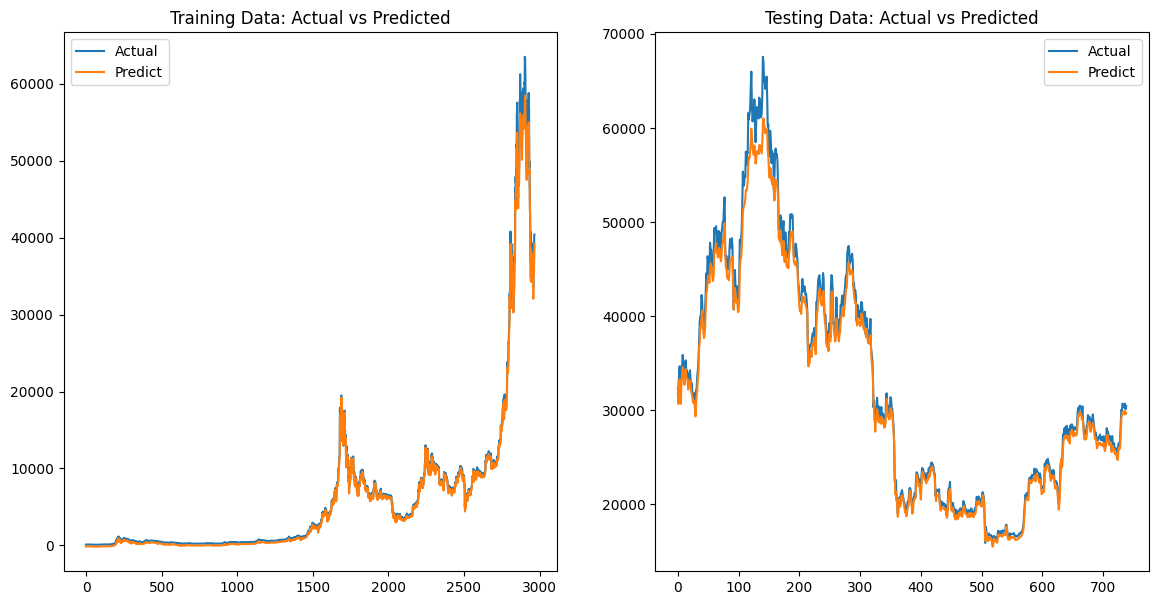

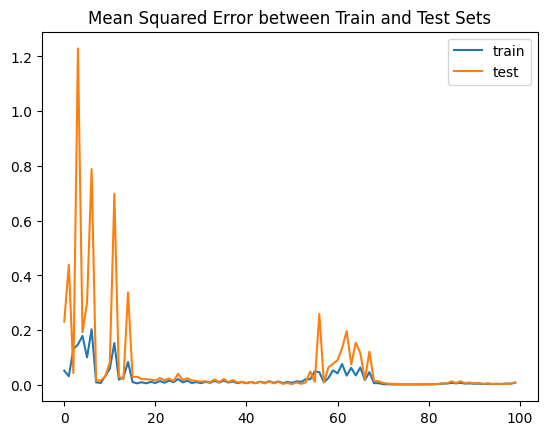

                    Train_Data C  Test_Data C
RMSE                  399525.955  2166629.358
R2 Score                   0.997        0.987
MAE                      357.471     1050.933
Explained Variance         0.998        0.993


In [25]:
train_comparison_df_multi,test_comparison_df_multi = lstm_multivariate_ohlcv.make_predictions()
lstm_multivariate_ohlcv.plot_predictions(train_comparison_df_multi, test_comparison_df_multi)
lstm_multivariate_ohlcv.plot_history()
results_df_multi = lstm_multivariate_ohlcv.evaluate_model(train_comparison_df_multi, test_comparison_df_multi)
print(results_df_multi)

In [26]:
stop

NameError: name 'stop' is not defined

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [ ]:
target_columns_uni = 'Close'  # univariate target
target_columns_multi = ['Open', 'High', 'Low', 'Close']  # multivariate targets
seq_length = 5  # sequence length
splitter = 0.8  # split ratio for train-test split

In [ ]:
# For Univariate LSTM model with 'Close' column
preprocessor_uni = DataPreprocessing(data, target_columns_uni)
data_normalized_uni = preprocessor_uni.normalize_and_scale()
X_train_close, y_train_close, X_test_close, y_test_close = preprocessor_uni.split_data(splitter, output_shape='3D')
print(X_train_close.shape, y_train_close.shape, X_test_close.shape, y_test_close.shape)
preprocessor_uni.visualize_split(y_train_close, y_test_close)

In [ ]:
# For Multivariate LSTM model with ('Open', 'High', 'Low', 'Close') columns
target_columns_multi = ['Open', 'High', 'Low', 'Close']
preprocessor_multi = DataPreprocessing(data, target_columns_multi)
data_normalized_multi = preprocessor_multi.normalize_and_scale()
X_train_ohlcv, y_train_ohlcv, X_test_ohlcv, y_test_ohlcv = preprocessor_multi.split_data(splitter=0.2, output_shape='3D')
print(X_train_ohlcv.shape, y_train_ohlcv.shape, X_test_ohlcv.shape, y_test_ohlcv.shape)
preprocessor_uni.visualize_split(y_train_close, y_test_close)

In [ ]:
# For Multivariate LSTM model with ('Open', 'High', 'Low', 'Close') columns
preprocessor_multi = DataPreprocessing(data, target_columns_multi)
data_normalized_multi = preprocessor_multi.normalize_and_scale()
X_train_ohlcv, y_train_ohlcv, X_test_ohlcv, y_test_ohlcv = preprocessor_multi.split_data(splitter=0.8, output_shape='3D')
print(X_train_ohlcv.shape, y_train_ohlcv.shape, X_test_ohlcv.shape, y_test_ohlcv.shape)

lstm_multivariate_ohlcv = LSTM_Models(X_train_ohlcv, y_train_ohlcv, X_test_ohlcv, y_test_ohlcv, multi_model, 'uni')
lstm_multivariate_ohlcv.train_model(epochs=100, batch_size=50)

In [ ]:
train_comparison_df_multi,test_comparison_df_multi = lstm_multivariate_ohlcv.make_predictions()
lstm_multivariate_ohlcv.plot_predictions(train_comparison_df_multi, test_comparison_df_multi)
lstm_multivariate_ohlcv.plot_history()
results_df_multi = lstm_multivariate_ohlcv.evaluate_model(train_comparison_df_multi, test_comparison_df_multi)
print(results_df_multi)

# Block 6 - Linear Regression Models

In [ ]:
class LinearRegression_Model:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = LinearRegression()

    def train_model(self):
        self.model.fit(self.X_train, self.y_train)

    def make_predictions(self):
        self.train_predict = self.model.predict(self.X_train)
        self.test_predict = self.model.predict(self.X_test)
        return self.train_predict, self.test_predict

    def plot_predictions(self):
        plt.figure(figsize=(14, 7))
        plt.plot(self.y_test, label='Actual')
        plt.plot(self.test_predict, label='Predicted')
        plt.title('Test Data: Actual vs Predicted')
        plt.legend()
        plt.show()

    def evaluate_model(self):
        train_rmse = mean_squared_error(self.y_train, self.train_predict, squared=False)
        train_mae = mean_absolute_error(self.y_train, self.train_predict)
        train_mse = mean_squared_error(self.y_train, self.train_predict)
        train_r2 = r2_score(self.y_train, self.train_predict)

        test_rmse = mean_squared_error(self.y_test, self.test_predict, squared=False)
        test_mae = mean_absolute_error(self.y_test, self.test_predict)
        test_mse = mean_squared_error(self.y_test, self.test_predict)
        test_r2 = r2_score(self.y_test, self.test_predict)

        results_df = pd.DataFrame({
            'Metric': ['RMSE', 'MAE', 'MSE', 'R2'],
            'Train': [train_rmse, train_mae, train_mse, train_r2],
            'Test': [test_rmse, test_mae, test_mse, test_r2]
        })

        return results_df


In [ ]:
# Initialize and train the model
linear_model = LinearRegression_Model(X_train, y_train, X_test, y_test)
linear_model.train_model()

# Make predictions
train_predict, test_predict = linear_model.make_predictions()

# Plot the predictions
linear_model.plot_predictions()

# Evaluate the model
results = linear_model.evaluate_model()
print(results)


In [ ]:
class LogisticRegression_Models:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = LogisticRegression()

    def train_model(self):
        self.model.fit(self.X_train, self.y_train)

    def make_predictions(self):
        train_predict = self.model.predict(self.X_train)
        test_predict = self.model.predict(self.X_test)
        return train_predict, test_predict
    
    def plot_predictions(self):
        plt.figure(figsize=(14, 7))
        plt.plot(self.y_test, label='Actual')
        plt.plot(self.y_test_pred, label='Predicted')
        plt.title('Test Data: Actual vs Predicted')
        plt.legend()
        plt.show()

    def evaluate_model(self, train_predict, test_predict):
        train_rmse = mean_squared_error(self.y_train, train_predict, squared=False)
        train_mae = mean_absolute_error(self.y_train, train_predict)
        train_mse = mean_squared_error(self.y_train, train_predict)
        train_r2 = r2_score(self.y_train, train_predict)

        test_rmse = mean_squared_error(self.y_test, test_predict, squared=False)
        test_mae = mean_absolute_error(self.y_test, test_predict)
        test_mse = mean_squared_error(self.y_test, test_predict)
        test_r2 = r2_score(self.y_test, test_predict)

        results_df = pd.DataFrame({
            'Metric': ['RMSE', 'MAE', 'MSE', 'R2'],
            'Train': [train_rmse, train_mae, train_mse, train_r2],
            'Test': [test_rmse, test_mae, test_mse, test_r2]
        })

        return results_df

# Block 8 - FB Prophet Models

In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


class ProphetModel:
    def __init__(self, df):
        df.reset_index(level=0, inplace=True)
        self.df = df.rename(columns={"Date": "ds", "Close": "y"})
        self.model = Prophet()

    def train_model(self):
        self.model.fit(self.df)

    def make_forecast(self, periods):
        future = self.model.make_future_dataframe(periods=periods)
        forecast = self.model.predict(future)
        self.forecast = forecast
        return forecast  # Return the forecast DataFrame


    def plot_forecast(self):
        return self.model.plot(self.forecast)

    def evaluate_model(self):
        df_cv = cross_validation(self.model, horizon='30 days')
        df_p = performance_metrics(df_cv)
        
        rmse = np.mean(df_p['rmse'])
        mae = np.mean(df_p['mae'])
        mse = np.mean(df_p['mse'])
        r2 = np.mean(df_p['coverage'])

        eval_df = pd.DataFrame({
            'Metric': ['RMSE', 'MAE', 'MSE', 'R2'],
            'Value': [rmse, mae, mse, r2]
        })

        return eval_df

    def plot_residuals(self):
        df_res = self.df.copy()
        df_res['yhat'] = self.forecast['yhat']
        df_res['residuals'] = df_res['y'] - df_res['yhat']
        plt.figure(figsize=(10,6))
        plt.plot(df_res['ds'], df_res['residuals'], label='Residuals')
        plt.title('Residuals over time')
        plt.show()
    
    def get_predictions_df(self, periods):
        df_pred = self.make_forecast(periods)
        compare_df = df_pred.set_index('ds')[['yhat']].join(self.df.set_index('ds'))
        compare_df = compare_df.rename(columns={'yhat': 'Predicted', 'y': 'Actual'})
        return compare_df


In [ ]:
# Create an instance of the ProphetModel class
univariate_model = ProphetModel(data)
# Train the model
univariate_model.train_model()
# Make a forecast
univariate_model.make_forecast(30) # adjust the number of periods as needed
# Evaluate the model
evaluation = univariate_model.evaluate_model()
print(evaluation)
# Plot residuals
univariate_model.plot_residuals()
# Get the predictions DataFrame
predictions_df = univariate_model.get_predictions_df(30) # adjust the number of periods as needed
print(predictions_df)

# Block 9 - AMZ Deep Time Models

In [ ]:
import pandas as pd
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions

class DeepTimeModel:
    def __init__(self, df, column_name):
        self.df = df
        self.column_name = column_name
        self.model = None
        self.predictor = None
        self.forecast = None

    def train_model(self, prediction_length):
        dataset = ListDataset([{
            "start": self.df.index[0],
            "target": self.df[self.column_name]
        }], freq = "D")
        
        estimator = DeepAREstimator(freq="D", 
                                    prediction_length=prediction_length, 
                                    trainer=Trainer(epochs=10))
        self.model = estimator.train(training_data=dataset)
    
    def get_predictions(self, test_data):
        predictor = self.model.predict(test_data)
        self.predictor = predictor
        return predictor


In [ ]:
# Create an instance of the DeepTimeModel class
deeptime_model = DeepTimeModel(df, 'column_name')
# Train the model
deeptime_model.train_model(prediction_length=30)
# Get the predictions
predictions = deeptime_model.get_predictions(test_data)


# Block 10 - FlowForecastModel


In [ ]:
from flood_forecast.trainer import train_function
import pandas as pd

class FlowForecastModel:
    def __init__(self, csv_path, target_col):
        self.csv_path = csv_path
        self.target_col = target_col
        self.model = None

    def train_model(self, epochs=1):
        model_params = {"n_time_series":3, "hidden_dim":20, "output_dim":1, "n_layers":2}
        dataset_params = {
            "file_path": self.csv_path,
            "forecast_history":10,
            "forecast_length":5,
            "relevant_cols": ["c1", "c2", "c3"],
            "target_col": [self.target_col],
            "scaling": "StandardScaler",
            "interpolate_param": False
        }
        
        g = {
            "model_name": "Transformer",
            "model_type": "PyTorch",
            "model_params": model_params,
            "dataset_params": dataset_params,
            "early_stopping": False,
        }

        self.model = train_function("Transformer", dict(g), "1")


In [ ]:
flow_forecast_model = FlowForecastModel('/path/to/your.csv', 'column_name')
flow_forecast_model.train_model(epochs=30)


In [ ]:
This example uses the transformer model provided by the Flow-Forecast library. Please replace '/path/to/your.csv' with your actual .csv file path, 'column_name' with the name of the column you want to predict, and adjust other parameters according to your needs.

Please note that flow-forecast relies on PyTorch and it's best to run this on a machine with a GPU if possible.

In [33]:
from cryptocmd import CmcScraper

class DataCollector:
    def collect_data(self):
        # Initialize scraper
        scraper = CmcScraper("BTC")

        # Get data
        data = scraper.get_dataframe()

        return data
from sklearn.preprocessing import StandardScaler

class DataPreprocessor:
    def preprocess_data(self, data):
        # Check for missing values
        data = data.dropna()

        # Normalize and scale data
        scaler = StandardScaler()
        data = scaler.fit_transform(data)

        return data
from sklearn.model_selection import train_test_split

class ModelBuilder:
    def build_model(self, model, data):
        # Split data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(data.drop('Close', axis=1), data['Close'], test_size=0.2, random_state=42)

        # Fit model
        model.fit(X_train, y_train)

        return model
from sklearn.metrics import mean_squared_error, r2_score

class ModelEvaluator:
    def evaluate_model(self, model, data):
        # Split data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(data.drop('Close', axis=1), data['Close'], test_size=0.2, random_state=42)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Model: {model.__class__.__name__}, MSE: {mse}, R2 Score: {r2}")
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

class ModelSelector:
    def select_models(self):
        # Select models
        models = [LinearRegression(), RandomForestRegressor(), SVR()]

        return models



def main():
    # Collect data
    collector = DataCollector()
    data = collector.collect_data()

    # Preprocess data
    preprocessor = DataPreprocessor()
    data = preprocessor.preprocess_data(data)

    # Select models
    selector = ModelSelector()
    models = selector.select_models()

    # Build and evaluate models
    builder = ModelBuilder()
    evaluator = ModelEvaluator()
    for model in models:
        model = builder.build_model(model, data)
        evaluator.evaluate_model(model, data)

if __name__ == "__main__":
    main()


TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>)

In [39]:
# Block 1 - load data with CmC Scrapper
class DataCollector:
    """
    This class is responsible for fetching and formatting cryptocurrency data.

    Input:
        crypto_symbol (str): The symbol of the cryptocurrency, e.g., "BTC" for Bitcoin.

    Methods:
        get_cryptocmd_data: Fetches cryptocurrency data and returns a formatted DataFrame.
        get_display_data: Fetches and formats cryptocurrency data for display purposes.
    """
    def __init__(self, crypto_symbol: str):
        self.crypto_symbol = crypto_symbol

    def _fetch_cryptocmd_data(self) -> pd.DataFrame:
        try:
            scraper = CmcScraper(self.crypto_symbol)
            df = scraper.get_dataframe()
            if not {'Date', 'Open', 'High', 'Low', 'Close', 'Market Cap', 'Volume'}.issubset(df.columns):
                raise ValueError("Some expected columns are missing in the data.")
            return df
        except Exception as e:
            print(f'An error occurred while fetching data: {e}')
            raise  # Propagate the exception

    def get_cryptocmd_data(self) -> pd.DataFrame:
        df = self._fetch_cryptocmd_data()
        df.set_index('Date', inplace=True)
        df.index = pd.to_datetime(df.index)
        return df.round(2)

    @staticmethod
    def _format_monetary_value(value: float) -> str:
        return "${:,.2f}".format(value)

    @staticmethod
    def _format_volume_value(value: float) -> str:
        if value > 1e9:
            return "{:.2f}B".format(value/1e9)
        elif value > 1e6:
            return "{:.2f}M".format(value/1e6)
        else:
            return "{:,.2f}".format(value)

    def get_display_data(self) -> pd.DataFrame:
        display_df = self.get_cryptocmd_data().copy()
        monetary_columns = ['Open', 'High', 'Low', 'Close']
        display_df[monetary_columns] = display_df[monetary_columns].applymap(self._format_monetary_value)

        # Check and apply volume formatting only if they are of numeric type
        volume_like_columns = ['Volume', 'Market Cap']
        for column in volume_like_columns:
            if pd.api.types.is_numeric_dtype(display_df[column]):
                display_df[column] = display_df[column].apply(self._format_volume_value)

        return display_df
    
class DataPreprocessor:
    """
    This class preprocesses the data obtained from the DataCollector.

    Methods:
        preprocess_data: Takes raw DataFrame as input, checks for missing values, normalizes and scales numerical data.
    """
    def preprocess_data(self, data):
        # Check for missing values
        if data.isnull().sum().sum() > 0:  # Additional null check step
            print("Data contains NaN values.")
            data = data.dropna()  # Drop rows with missing values

        # Separate monetary and volume columns
        monetary_columns = ['Open', 'High', 'Low', 'Close']
        volume_like_columns = ['Volume', 'Market Cap']

        # Create a StandardScaler instance
        scaler = StandardScaler()

        # Normalize and scale monetary columns
        if set(monetary_columns).issubset(data.columns):
            data[monetary_columns] = scaler.fit_transform(data[monetary_columns])

        # Normalize and scale volume like columns only if they are of numeric type
        for column in volume_like_columns:
            if pd.api.types.is_numeric_dtype(data[column]):
                # Reshape because fit_transform expects 2D arrays
                data[column] = scaler.fit_transform(data[column].values.reshape(-1, 1))

        return data
    
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense
from prophet import Prophet

class ModelBuilder:
    """
    A wrapper class providing build runs for various models.

    Methods:
        __init__: Initializes the model builder with specified model type.
        build: Builds the model as per the specified type.
    """

    def __init__(self, model_type):
        self.model_type = model_type
        self.model = None

    def build(self, model_params):
        if self.model_type == 'linear_regression':
            self.model = self.build_linear_regression()
        elif self.model_type == 'lstm_single_layer':
            self.model = self.build_lstm_single_layer(model_params)
        elif self.model_type == 'lstm_multi_layer':
            self.model = self.build_lstm_multi_layer(model_params)
        elif self.model_type == 'prophet':
            self.model = self.build_prophet(model_params)
        else:
            print(f'Invalid model type: {self.model_type}')
            raise ValueError
        return self.model

    @staticmethod
    def build_linear_regression():
        model = LinearRegression()
        print("Linear Regression model built.")
        return model

    def build_lstm_single_layer(self, model_params):
        model = Sequential()
        model.add(LSTM(units=model_params['units'], input_shape=(model_params['input_shape'])))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        print("Single layer LSTM model built.")
        return model

    def build_lstm_multi_layer(self, model_params):
        model = Sequential()
        # Adding the first LSTM layer and some Dropout regularisation
        model.add(LSTM(units=model_params['units'], return_sequences=True, input_shape=(model_params['input_shape'])))
        model.add(Dropout(0.2))
        # Adding a second LSTM layer and some Dropout regularisation
        model.add(LSTM(units=model_params['units'], return_sequences=True))
        model.add(Dropout(0.2))
        # Adding a third LSTM layer and some Dropout regularisation
        model.add(LSTM(units=model_params['units']))
        model.add(Dropout(0.2))
        # Adding the output layer
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        print("Multi-layer LSTM model built.")
        return model

    @staticmethod
    def build_prophet(model_params):
        model = Prophet(**model_params)
        print("Prophet model built.")
        return model

def train_model(model_builder, X_train, y_train, X_val=None, y_val=None, epochs=10, batch_size=32):
    """
    Train the specified model.

    Parameters:
        model_builder (ModelBuilder): An instance of ModelBuilder.
        X_train (np.array): Training features.
        y_train (np.array): Training labels.
        X_val (np.array): Validation features. Default is None.
        y_val (np.array): Validation labels. Default is None.
        epochs (int): Number of epochs. Default is 10.
        batch_size (int): Batch size. Default is 32.
    Returns:
        model: Trained model.
    """
    if isinstance(model_builder.model, Prophet):
        model = model_builder.model.fit(y_train) # Assuming y_train is a DataFrame with 'ds' and 'y' columns for Prophet
    else:
        model_builder.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)
        model = model_builder.model
    print("Model trained.")
    return model

from sklearn.metrics import mean_squared_error

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model.

    Parameters:
        model: Trained model.
        X_test (np.array): Test features.
        y_test (np.array): Test labels.

    Returns:
        MSE: Mean Squared Error on the test set.
    """
    
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)

    return mse

In [40]:
data_collector = DataCollector("BTC")


In [41]:
data_preprocessor = DataPreprocessor()
raw_data = data_collector.get_cryptocmd_data()  # get raw data
data = data_preprocessor.preprocess_data(raw_data)  # preprocessed data


In [43]:
train_size = int(len(data) * 0.8)  # 80% for training
train, test = data[:train_size], data[train_size:]


In [44]:
model_builder = ModelBuilder('lstm_single_layer')


In [47]:
params = {'units': 50, 'input_shape': (train.shape[1], 1)}
model = model_builder.build(params)
model = train_model(model_builder, train, test, epochs=50, batch_size=32)


Single layer LSTM model built.


ValueError: Data cardinality is ambiguous:
  x sizes: 2973
  y sizes: 744
Make sure all arrays contain the same number of samples.

In [46]:
mse = evaluate_model(model, test)
print(f'Test MSE: {mse}')


TypeError: evaluate_model() missing 1 required positional argument: 'y_test'